## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
# additional torch packages
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from sklearn import metrics
from torchvision.transforms import ToTensor
import os
from glob import glob
from PIL import Image
import time

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

## Import method, PIL, to get images as Tensors
As there were issues converting to Tensors when using Rasterio for import, due to data types not matching.

In [3]:
image_path = 'data'
label_path = 'labels'

images_tensors = []
labels_tensors = []

# Getting a sorted list of filenames from both image and label directories
image_files = sorted(os.listdir(image_path))
label_files = sorted(os.listdir(label_path))

# Zipping the sorted filenames so they correspond to each other
for img_filename, lbl_filename in zip(image_files, label_files):
    if img_filename[9:12] == lbl_filename[7:10]:  # Matching filenames by position
        img_filepath = os.path.join(image_path, img_filename)
        lbl_filepath = os.path.join(label_path, lbl_filename)

        # Reading and converting images to tensors
        single_image = Image.open(img_filepath)
        single_image = ToTensor()(single_image)
        images_tensors.append(single_image)

        # Reading and converting labels to tensors
        single_label = Image.open(lbl_filepath)
        single_label = ToTensor()(single_label)
        labels_tensors.append(single_label)


## Visualize first 10 images and their labels

Comment: Somehow it seems like the gray scale changes the order of the colors. Where they were white before, they are now black?

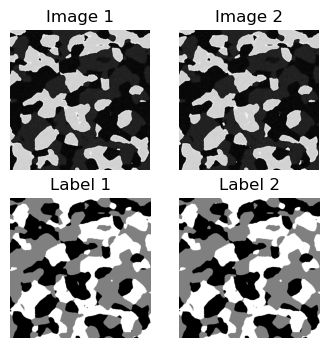

In [35]:
# Plot the first 5 images and first 5 labels in a 2x5 subplot
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

for i in range(2):
    axes[0, i].imshow(images_tensors[i].squeeze(), cmap='gray')
    axes[0, i].set_title('Image {}'.format(i + 1))
    axes[0, i].axis('off')

    axes[1, i].imshow(labels_tensors[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Label {}'.format(i + 1))
    axes[1, i].axis('off')

## Data transformation and preparation

* Reshape images to 256x256 pixel
* Normalize images
* Create data set
* Split in training, validation and test data
* Create data loader

In the train data loader, we keep the shuffle parameter True since we want samples from all classes to be uniformly present in a batch which is important for optimal learning and convergence of batch gradient-based optimization approaches.

In [13]:
images_float = [image.type(torch.FloatTensor) for image in images_tensors]
# make labels integers 0, 1, 2
labels_int = [label * 2 for label in labels_tensors]
# convert labels_cropped to be long tensor
labels_long = [label.long() for label in labels_int]
# remove the third dimension from labels
labels_long = [label.squeeze(0) for label in labels_long]

max_pixel = torch.max(torch.stack(images_float[0:400]))
# Normalize the images
images_normalized = [image / max_pixel for image in images_float]

# Build data sets

# Build Tensor dataset
dataset = TensorDataset(torch.stack(images_normalized), torch.stack(labels_long))

# Split in train (80%), validation (10%) and test (10%) sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Crop images and labels to 128x128 and 256x256
transform_train = transforms.CenterCrop((128, 128))
transform_val_test = transforms.CenterCrop((256, 256))

# apply transforms to train, val and test sets for the images and labels
train_set_cropped = [(transform_train(image), transform_train(label)) for image, label in train_set]
val_set_cropped = [(transform_val_test(image), transform_val_test(label)) for image, label in val_set]
test_set_cropped = [(transform_val_test(image), transform_val_test(label)) for image, label in test_set]

# batch size
batch_size = 4

# Build data loaders
train_loader = DataLoader(train_set_cropped, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_cropped, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set_cropped, batch_size=batch_size, shuffle=False)

print('shape of training set images: ', train_set_cropped[0][0].shape)
print('shape of training set labels: ', train_set_cropped[1][0].shape)
print('shape of validation set images: ', val_set_cropped[0][0].shape)
print('shape of validation set labels: ', val_set_cropped[1][0].shape)
print('shape of test set images: ', test_set_cropped[0][0].shape)
print('shape of test set labels: ', test_set_cropped[1][0].shape)


shape of training set images:  torch.Size([1, 128, 128])
shape of training set labels:  torch.Size([1, 128, 128])
shape of validation set images:  torch.Size([1, 256, 256])
shape of validation set labels:  torch.Size([1, 256, 256])
shape of test set images:  torch.Size([1, 256, 256])
shape of test set labels:  torch.Size([1, 256, 256])


In [16]:
# Crop images and labels to 256x256 and convert images to float
transform = transforms.CenterCrop((256, 256))
images_cropped = [transform(image) for image in images_tensors]
images_256 = [image.type(torch.FloatTensor) for image in images_cropped]
labels_cropped = [transform(label) for label in labels_tensors]

# # Convert labels to one-hot encoding
# labels_one_hot = [F.one_hot(label.squeeze().long(), num_classes=3).permute(2, 0, 1).float() for label in labels_cropped]

# # Stack the one-hot encoded labels together
# labels_stacked = torch.stack(labels_one_hot)

labels_cropped = [label * 2 for label in labels_cropped]
# convert labels_cropped to be long tensor
labels_cropped = [label.long() for label in labels_cropped]
# remove the third dimension from labels
labels_cropped = [label.squeeze(0) for label in labels_cropped]

print('shape of labels_cropped: ', labels_cropped[0].shape)

max_pixel = torch.max(torch.stack(images_256[0:400]))
# Normalize the images
images_normalized = [image / max_pixel for image in images_256]

# Build data sets

# Build Tensor dataset
dataset = TensorDataset(torch.stack(images_normalized), torch.stack(labels_cropped))

# Split in train (80%), validation (10%) and test (10%) sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# batch size
batch_size = 4

# Build data loader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # shuffle training set
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False) # no need to shuffle validation set
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) # no need to shuffle test set


print('shape of training set images: ', train_set[0][0].shape)
print('shape of training set labels: ', train_set[1][0].shape)
print('shape of validation set images: ', val_set[0][0].shape)
print('shape of validation set labels: ', val_set[1][0].shape)
print('shape of test set images: ', test_set[0][0].shape)
print('shape of test set labels: ', test_set[1][0].shape)

shape of labels_cropped:  torch.Size([256, 256])
shape of training set images:  torch.Size([1, 256, 256])
shape of training set labels:  torch.Size([1, 256, 256])
shape of validation set images:  torch.Size([1, 256, 256])
shape of validation set labels:  torch.Size([1, 256, 256])
shape of test set images:  torch.Size([1, 256, 256])
shape of test set labels:  torch.Size([1, 256, 256])


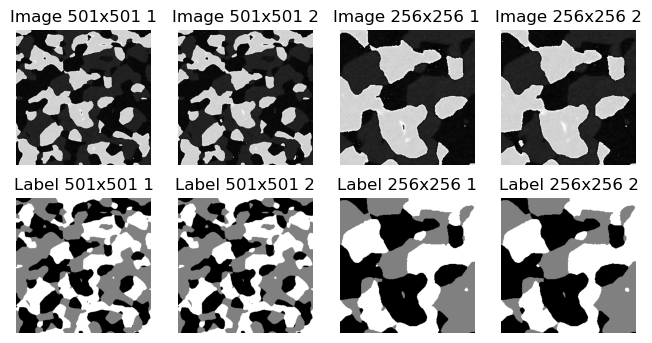

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for i in range(2):
    axes[0, i].imshow(images_tensors[i].squeeze(), cmap='gray')
    axes[0, i].set_title('Image 501x501 {}'.format(i + 1))
    axes[0, i].axis('off')
    axes[0, i+2].imshow(images_cropped[i].squeeze(), cmap='gray')
    axes[0, i+2].set_title('Image 256x256 {}'.format(i + 1))
    axes[0, i+2].axis('off')

    axes[1, i].imshow(labels_tensors[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Label 501x501 {}'.format(i + 1))
    axes[1, i].axis('off')
    axes[1, i+2].imshow(labels_cropped[i].squeeze(), cmap='gray')
    axes[1, i+2].set_title('Label 256x256 {}'.format(i + 1))
    axes[1, i+2].axis('off')

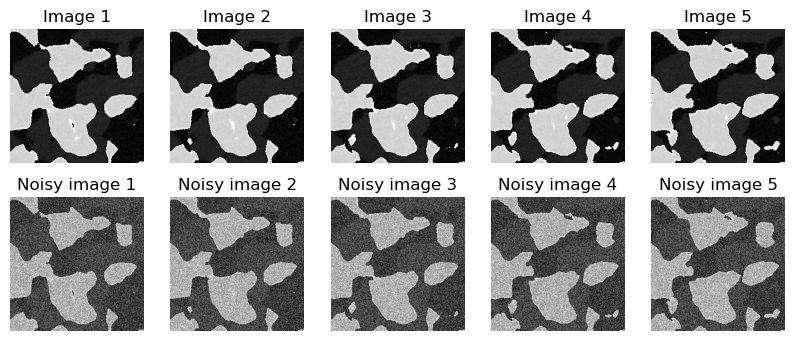

In [17]:
from noise_function import add_noise_to_tensor as add_noise

# Add noise to the images
images_noisy = [add_noise(image) for image in images_256]

# Plot the first 5 images and first 5 labels in a 2x5 subplot
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(5):
    axes[0, i].imshow(images_256[i].squeeze(), cmap='gray')
    axes[0, i].set_title('Image {}'.format(i + 1))
    axes[0, i].axis('off')

    axes[1, i].imshow(images_noisy[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Noisy image {}'.format(i + 1))
    axes[1, i].axis('off')

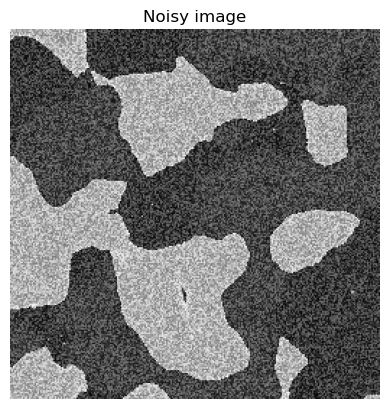

<Figure size 640x480 with 0 Axes>

In [25]:
# plot one noisy image
plt.imshow(images_noisy[0].squeeze(), cmap='gray')
plt.title('Noisy image')
plt.axis('off')
plt.show()
plt.savefig('figures/noisy_image.png')

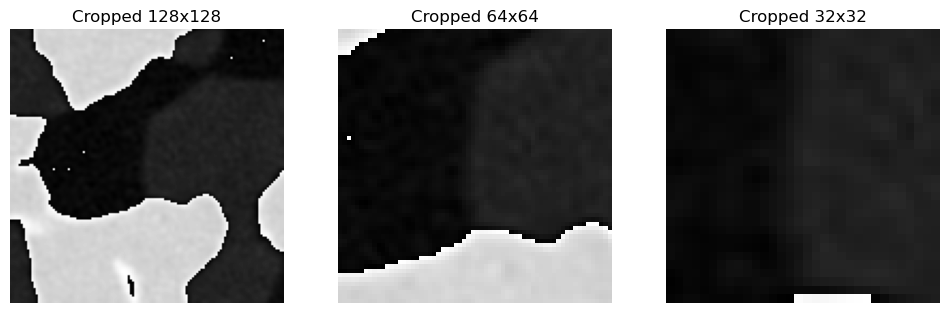

In [22]:
# Crop images to different sizes
transform_128 = transforms.CenterCrop((128, 128))
transform_64 = transforms.CenterCrop((64, 64))
transform_32 = transforms.CenterCrop((32, 32))

# Apply transforms to the images
images_cropped_128 = [transform_128(image) for image in images_tensors]
images_cropped_64 = [transform_64(image) for image in images_tensors]
images_cropped_32 = [transform_32(image) for image in images_tensors]

# Plot the cropped images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(images_cropped_128[0].squeeze(), cmap='gray')
axes[0].set_title('Cropped 128x128')
axes[0].axis('off')

axes[1].imshow(images_cropped_64[0].squeeze(), cmap='gray')
axes[1].set_title('Cropped 64x64')
axes[1].axis('off')

axes[2].imshow(images_cropped_32[0].squeeze(), cmap='gray')
axes[2].set_title('Cropped 32x32')
axes[2].axis('off')
plt.savefig('figures/cropped_images.png')
plt.show()


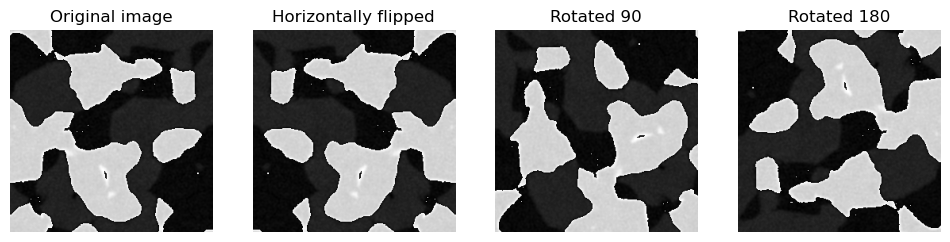

In [30]:
# crop images to 256x256
transform = transforms.CenterCrop((256, 256))
images_cropped = [transform(image) for image in images_tensors]

# Define data augmentation transformations
hflip  = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    
])

# Define data augmentation transformations
rot180  = transforms.Compose([
    transforms.RandomRotation(degrees=[180, 180]), # Randomly rotate the image by a certain degree
])

# Define data augmentation transformations
rot90  = transforms.Compose([
    transforms.RandomRotation(degrees=[90, 90]), # Randomly rotate the image by a certain degree
])

# apply the transformations to the images
images_hflip = [hflip(image) for image in images_cropped]
images_rot90 = [rot90(image) for image in images_cropped]
images_rot180 = [rot180(image) for image in images_cropped]

# Plot the transformed images and the original image in a 1x4 subplot
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(images_cropped[0].squeeze(), cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(images_hflip[0].squeeze(), cmap='gray')
axes[1].set_title('Horizontally flipped')
axes[1].axis('off')

axes[2].imshow(images_rot90[0].squeeze(), cmap='gray')
axes[2].set_title('Rotated 90')
axes[2].axis('off')

axes[3].imshow(images_rot180[0].squeeze(), cmap='gray')
axes[3].set_title('Rotated 180')
axes[3].axis('off')

plt.savefig('figures/image_flips.png')

## Build U-Net Model

Follow this example: https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3 

$\textbf{Number of Classes:}$

3 classes:
* Bright/white: The bright phase is nickel
* Gray: The gray phase is YSZ
* Dark: Pores and free space around the samples are dark

$\textbf{Encoder:}$

The encoder is a series of convolutional and pooling layers that progressively downsample the input image to extract features at multiple scales.

In the Encoder, the size of the image is gradually reduced while the depth gradually increases. This basically means the network learns the “WHAT” information in the image, however, it has lost the “WHERE” information.

Input image: (1 x 501 x 501)

* In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
* Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.

$\textbf{Decoder:}$

The decoder consists of a series of convolutional and upsampling layers that upsample the feature maps to the original input image size while also incorporating the high-resolution features from the encoder. This allows the decoder to produce segmentation masks that have the same size as the original input image.

In the Decoder, the size of the image gradually increases while the depth gradually decreases. This basically means the network learns the “WHERE” information in the image, by gradually applying up-sampling.

$\textbf{Final Layer:}$

At the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.

$\textbf{Forward method:}$

The forward method specifies how the input is processed through the network. The input image is first passed through the encoder layers to extract the features. Then, the decoder layers are used to upsample the features to the original image size while concatenating the corresponding encoder feature maps. Finally, the output layer uses a 1x1 convolutional layer to map the features to the desired number of output classes.

In [9]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [16]:
# with batch normalization

class Unet(nn.Module):
    def __init__(self, n_class):
        super(Unet, self).__init__()

        # Encoder (downsampling)
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(1024)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(1024)

        # Decoder (upsampling)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn11d = nn.BatchNorm2d(512)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(256)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(64)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.bn11d(self.d11(xu11)))
        xd12 = F.relu(self.bn12d(self.d12(xd11)))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32[:, :, :xu2.size(2), :xu2.size(3)]], dim=1)
        xd21 = nn.functional.relu(self.bn21d(self.d21(xu22)))
        xd22 = nn.functional.relu(self.bn22d(self.d22(xd21)))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22[:, :, :xu3.size(2), :xu3.size(3)]], dim=1)
        xd31 = F.relu(self.bn31d(self.d31(xu33)))
        xd32 = F.relu(self.bn32d(self.d32(xd31)))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12[:, :, :xu4.size(2), :xu4.size(3)]], dim=1)
        xd41 = F.relu(self.bn41d(self.d41(xu44)))
        xd42 = F.relu(self.bn42d(self.d42(xd41)))

        # Output layer
        out = self.outconv(xd42)
        # restore output to original shape
        out = F.interpolate(out, size=(501,501), mode='bilinear', align_corners=False)

        return out

net = Unet(3) # 3 classes
if use_cuda:
    net.cuda()

device = torch.device('cpu')  # use cuda or cpu
net.to(device)
print(net)

Unet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

## Define loss function and optimizer

In [17]:
# loss function: Cross entropy loss (for multi-class classification)
# What output activation function should we use?
loss_unet = nn.CrossEntropyLoss()

# optimizer: ADAM
optimizer_unet = optim.Adam(net.parameters(), lr=1e-3)

## Test forward pass on dummy data

In [14]:
# Create a dummy input tensor
dummy_input = torch.randn(8, 1, 501, 501)  # (batch_size, channels, height, width)

# Forward pass
with torch.no_grad():
    if use_cuda:
        dummy_input = dummy_input.cuda()
    output = net(dummy_input)

# Print the output shape
print("Output shape:", output.shape)
#print(output)

Output shape: torch.Size([8, 3, 496, 496])


## Train the network

In [18]:
# number of epochs to train the model
n_epochs = 50

# function to calculate accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0) * labels.size(1) * labels.size(2)
    correct = (predicted == labels).sum().item()
    return correct / total

# Initialize lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    # Training
    net.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_loader:
        images, labels = get_variable(images), get_variable(labels)
        optimizer_unet.zero_grad()

        outputs = net(images)
        loss = loss_unet(outputs, labels.argmax(dim=1))
        loss.backward()
        optimizer_unet.step()

        train_loss += loss.item() * images.size(0)
        train_acc += accuracy(outputs, labels.argmax(dim=1)) * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)

    # Store training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = get_variable(images), get_variable(labels)
            outputs = net(images)
            loss = loss_unet(outputs, labels.argmax(dim=1))

            val_loss += loss.item() * images.size(0)
            val_acc += accuracy(outputs, labels.argmax(dim=1)) * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)

    # Store validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch + 1}/{n_epochs}]')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Plot the train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# show val loss as text on plot for last epoch
plt.text(n_epochs, val_losses[-1], f'{val_losses[-1]:.4f}')
plt.savefig('figures/unet_loss.png')

# Plot the train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
# show val accuracy as text on plot for last epoch
plt.text(n_epochs, val_accuracies[-1], f'{val_accuracies[-1]:.4f}')
plt.savefig('figures/unet_accuracy.png')

# For just 1 image, show the original, the label and the prediction side by side
net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = get_variable(images), get_variable(labels)
        outputs = net(images)
        break
    
image = images[0].squeeze().cpu().numpy()
label = labels[0].squeeze().cpu().numpy()
output = outputs[0].squeeze().cpu().numpy()

# Rearrange dimensions from (3, 256, 256) to (256, 256, 3)
image = np.transpose(image, (1, 2, 0))  # If image shape is (3, 256, 256)
label = np.transpose(label, (1, 2, 0))  # If label shape is (3, 256, 256)
output = np.transpose(output, (1, 2, 0))  # If output shape is (3, 256, 256)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(label, cmap='gray')
axes[1].set_title('Actual Label')
axes[1].axis('off')

axes[2].imshow(output, cmap='gray')
axes[2].set_title('Predicted Label')
axes[2].axis('off')

plt.tight_layout()
# Save the figure to the 'Figures' folder
plt.savefig('figures/unet_sample_prediction.png')


KeyboardInterrupt: 

In [ ]:
# Test the model
net.eval() # prep model for evaluation
test_loss = 0
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        # send the input to device
        images, labels = images.to(device), labels.to(device)
        images = images.to(torch.float32)

        # Complete forward pass through model
        output = net(images)

        # Compute the loss
        loss = loss_unet(output, labels)

        # add the loss to the validation set's running loss 
        test_loss += loss

        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(output.data, 1)

        # compare predictions to true label
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # store true and predicted labels
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

# print test loss and accuracy
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %d%% (%d/%d)\n' % (100 * correct / total, correct, total))

In [ ]:
# print classification report
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
print(metrics.classification_report(y_true, y_pred))

# plot confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix', size=15)
plt.show()

In [ ]:
# compare original image with labels and predicted labels
# get the first batch of images and labels
images, labels = next(iter(test_loader))

# send the input to device
images, labels = images.to(device), labels.to(device)
images = images.to(torch.float32)

# Complete forward pass through model
output = net(images)

# get the predicted class from the maximum value in the output-list of class scores
_, predicted = torch.max(output.data, 1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0].cpu().numpy(), cmap='gray')
    ax.set_title("{} ({})".format(predicted[idx].item(), labels[idx].item()),
                 color=("green" if predicted[idx]==labels[idx] else "red"))

# plot the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    plt.imshow(labels[idx][0].cpu().numpy(), cmap='gray')
    ax.set_title("Label {}".format(idx+1))

# plot the corresponding predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    plt.imshow(predicted[idx][0].cpu().numpy(), cmap='gray')
    ax.set_title("Predicted Label {}".format(idx+1))

In [ ]:
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(images[j, 0, :, :], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Label')
        plt.imshow(labels_np[j, :, :], cmap='gray', vmin=0, vmax=3)  # adjust vmin and vmax based on your classes

        plt.subplot(1, 3, 3)
        plt.title('Predicted Output')
        plt.imshow(output_np[j].argmax(axis=0), cmap='gray', vmin=0, vmax=3)  # adjust vmin and vmax based on your classes

        plt.show()